# Shape analysis of curves with the Square Root Velocity metric

Lead author: Alice Le Brigant.

In this notebook, we demonstrate how to compute distances between curves in a way that does not depend on parametrization, i.e. that only depends on the shapes of the curves. This is achieved using the Square Root Velocity metric (see [SKJJ2011](#References)) on the space of parametrized curves starting at origin, and by quotienting out the action of reparametrization through an optimal matching algorithm (see [LAB2017](#References)). We will use the [`discrete_curves.py`](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/discrete_curves.py) module. Rotation can also be quotiented out using the `align` method of the [`pre-shape.py`](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/pre_shape.py) module, but we will not deal with these aspects here. See this [usecase](https://github.com/geomstats/geomstats/blob/master/notebooks/usecase_optic_nerve_heads_analysis_in_kendall_shape_space.ipynb) for details on the `pre_shape.py` module, or this  [other usecase](https://github.com/geomstats/challenge-iclr-2021/blob/main/Florent-Michel__Shape-Analysis-of-Cancer-Cells/submission_cell_shape_analysis.ipynb) for an application where both modules are used.

In [1]:
import matplotlib.pyplot as plt

import geomstats.backend as gs
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVTranslationMetric,
    insert_zeros,
)

INFO: Using numpy backend


## Example 1: plane curves

We start with a basic example in $\mathbb R^2$. 

In [2]:
r2 = Euclidean(dim=2)
k_sampling_points = 20

curves_r2 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=2, k_sampling_points=k_sampling_points, equip=False
)

In [3]:
parametrized_curve_a = lambda x: gs.transpose(
    gs.array([1 + 2 * gs.sin(gs.pi * x), 3 + 2 * gs.cos(gs.pi * x)])
)
parametrized_curve_b = lambda x: gs.transpose(
    gs.array([5 * gs.ones(len(x)), 4 * (1 - x) + 1])
)

In practice, we work with discrete curves, i.e. sample points from the parametrized curves. 

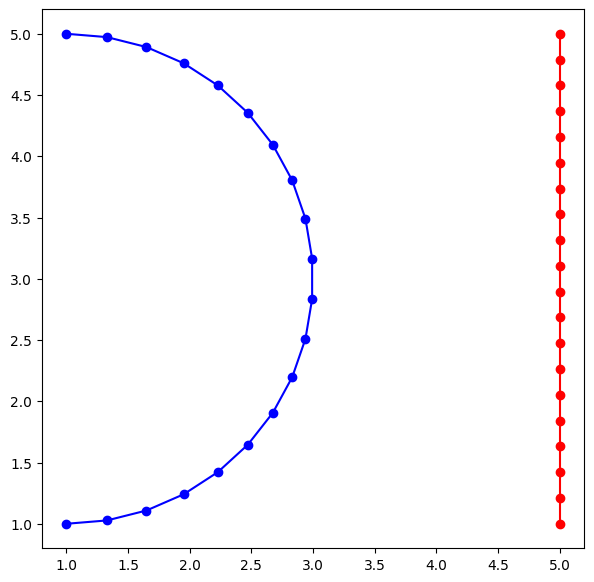

In [4]:
def plot_curve(curve, fmt="o-k", ax=None, add_origin=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    if add_origin:
        curve = insert_zeros(curve, axis=-2)
    ax.plot(curve[:, 0], curve[:, 1], fmt)

    return ax


sampling_points = gs.linspace(0.0, 1.0, k_sampling_points)
curve_a_trans = parametrized_curve_a(sampling_points)
curve_b_trans = parametrized_curve_b(sampling_points)

ax = plot_curve(curve_a_trans, "o-b", add_origin=False)
plot_curve(curve_b_trans, "o-r", ax=ax, add_origin=False)
plt.show()

We also need to remove translation (to obtain curves starting at origin), which can be seen as the projection of a point from the discrete curves to the discrete curves starting at origin.

<Figure size 700x700 with 0 Axes>

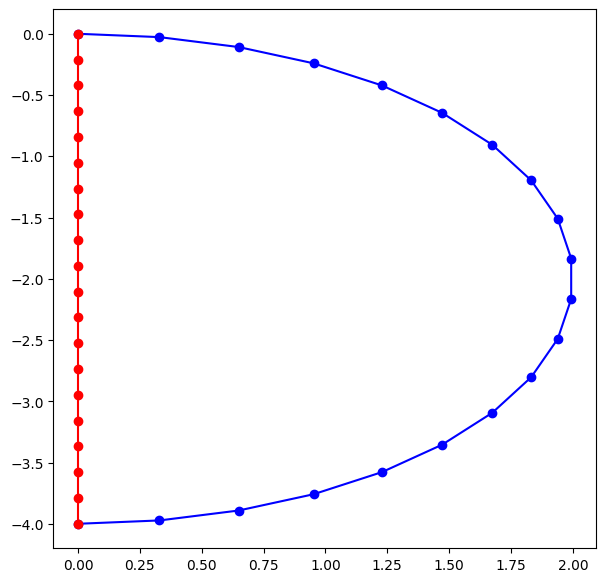

In [5]:
curve_a = curves_r2.projection(curve_a_trans)
curve_b = curves_r2.projection(curve_b_trans)

plt.figure(figsize=(7, 7))
ax = plot_curve(curve_a, "o-b")
plot_curve(curve_b, "o-r", ax=ax)
plt.show()

NB: we remove $(0., 0.)$ from the representation as we know all the curves start at the origin (though we still use it in the plot).

### Distance between parametrized curves starting at origin

The metric we use to compare parametrized curves is the so-called Square Root Velocity metric, that computes an $L^2$ distance between the velocities of the curves, suitably renormalized to get reparametrization invariance. See [SKJJ2011](#References) for more details.

In [6]:
curves_r2.equip_with_metric(SRVTranslationMetric)

curves_r2.metric.dist(point_a=curve_a, point_b=curve_b)

1.972134949925512

The distance, as any Riemannian distance, is computed as the length of the geodesic.

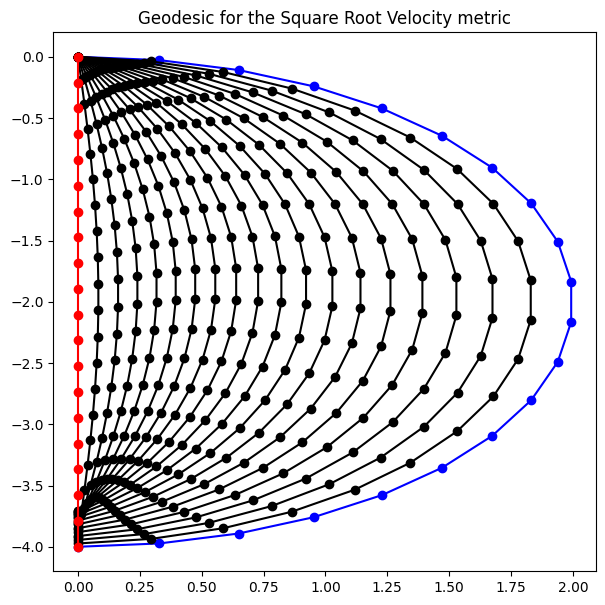

In [7]:
def plot_geodesic(geod_points, ax=None, add_origin=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    if add_origin:
        geod_points = insert_zeros(geod_points, axis=-2)
    ax.plot(geod_points[0, :, 0], geod_points[0, :, 1], "o-b")
    for i in range(1, n_times - 1):
        ax.plot(geod_points[i, :, 0], geod_points[i, :, 1], "o-k")
    ax.plot(geod_points[-1, :, 0], geod_points[-1, :, 1], "o-r")

    return ax


geod_fun = curves_r2.metric.geodesic(curve_a, curve_b)

n_times = 20
times = gs.linspace(0.0, 1.0, n_times)
geod = geod_fun(times)

plot_geodesic(geod)
plt.title("Geodesic for the Square Root Velocity metric")
plt.show()

The Square Root Velocity metric is reparametrization invariant in the sense that, if the two curves are reparametrized *in the same way*, the distance does not change.

In [8]:
curve_a_trans_resampled = parametrized_curve_a(sampling_points**2)
curve_b_trans_resampled = parametrized_curve_b(sampling_points**2)

curve_a_resampled = curves_r2.projection(curve_a_trans_resampled)
curve_b_resampled = curves_r2.projection(curve_b_trans_resampled)

curves_r2.metric.dist(curve_a_resampled, curve_b_resampled)

1.9694017211949013

NB: the (small) difference we see in the distances is related with the number of sampling points: it will go to zero as it increases.

The geodesic keeps the same shape.

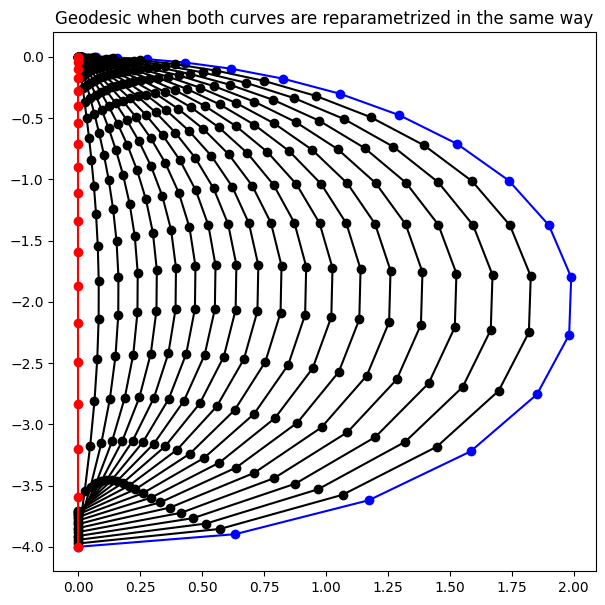

In [9]:
geod_fun_1 = curves_r2.metric.geodesic(curve_a_resampled, curve_b_resampled)
geod_1 = geod_fun_1(times)

plot_geodesic(geod_1)
plt.title("Geodesic when both curves are reparametrized in the same way")
plt.show()

However, if the curves are reparametrized in *different* ways, the distance changes, and so does the shape of the geodesic.

In [10]:
curves_r2.metric.dist(curve_a, curve_b_resampled)

2.0180332363264095

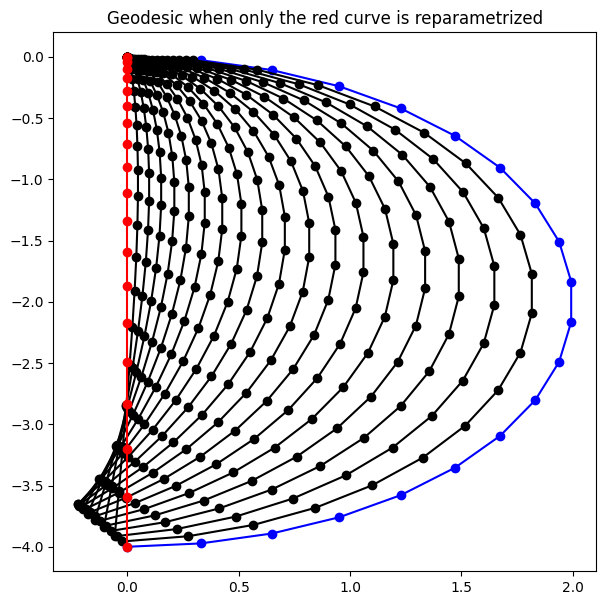

In [11]:
geod_fun_2 = curves_r2.metric.geodesic(curve_a, curve_b_resampled)
geod_2 = geod_fun_2(times)

plot_geodesic(geod_2)
plt.title("Geodesic when only the red curve is reparametrized")
plt.show()

### Distance between unparametrized curves

In order to completely quotient out parametrization, distances are computed in the base space of a fiber bundle where the fibers represent equivalent classes of curves with the same shape (i.e. equal modulo reparametrization). Any infinitesimal deformation of a curve can be split into the sum of vertical deformation (tangent to the fiber) that simply reparametrizes the curve without changing its shape, and a horizontal deformation (orthogonal to the fiber) that changes the shape. The distance between two unparametrized curves is then computed as the length of a horizontal geodesic linking their two fibers. 

In practice, to compute the horizontal geodesic linking the fibers of two discrete parametrized curves `curve_a` and `curve_b`, we can fix the parametrization of `curve_a`, and search for a reparametrization of `curve_b` (i.e. another discrete curve with same shape as `curve_b`) that best "matches" `curve_a`. 

Since geodesics that start with a horizontal velocity stay horizontal, a first idea would be the following: 

- compute the geodesic between `curve_a` and `curve_b`
- compute the horizontal part of its initial velocity vector
- shoot from `curve_a` using this horizontal vector.

In [12]:
curves_r2.equip_with_group_action("reparametrizations")
curves_r2.equip_with_quotient_structure()

geod_velocity = (n_times - 1) * (geod[1:] - geod[:-1])

geod_velocity_hor = curves_r2.fiber_bundle.horizontal_projection(
    geod_velocity, geod[:-1]
)
geod_velocity_ver = curves_r2.fiber_bundle.vertical_projection(geod_velocity, geod[:-1])

shooted_geod_fun = curves_r2.metric.geodesic(
    initial_point=curve_a, initial_tangent_vec=geod_velocity_hor[0]
)
shooted_geod = shooted_geod_fun(times)

The problem with this idea is that, while it yields a horizontal geodesic starting at `curve_a`, its end point does not belong to the fiber of `curve_b`: as we can see below, the end curve of the horizontal geodesic is not a reparametrization of the initial red curve, it does not have the same shape.

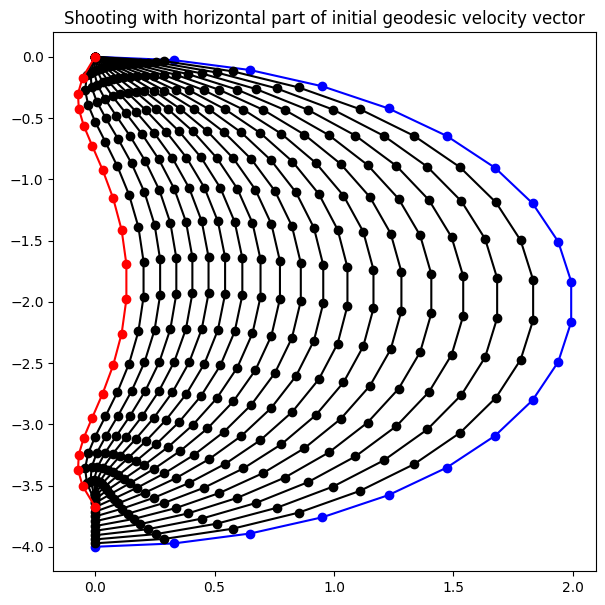

In [13]:
plot_geodesic(shooted_geod)
plt.title("Shooting with horizontal part of initial geodesic velocity vector")
plt.show()

To obtain a horizontal geodesic starting at `curve_a` and ending at a curve with same shape as `curve_b`, we use an iterative optimal matching algorithm [LAB2017](#References). This algorithm moves along the fiber of `curve_b` to find the best representative with respect to `curve_a` by iterating the following steps:

- step 1: compute the geodesic between `curve_a` and the current representative of `curve_b` (initially, `curve_b`)
- step 2: compute the path whose velocity is a reparametrization of the horizontal part of the geodesic velocity at all time, and set the new representative of `curve_b` to be the end point of this path.

Note that the first step yields a geodesic that is not horizontal, while the second step yields a horizontal path that is not geodesic. By iterating these two steps, the algorithm converges to a horizontal geodesic.

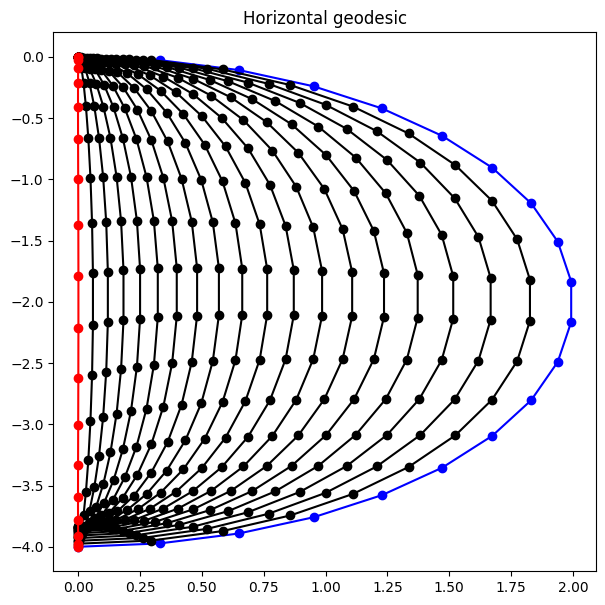

In [14]:
hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a, curve_b)
hgeod = hgeod_fun(times)

plot_geodesic(hgeod)
plt.title("Horizontal geodesic")
plt.show()

We can check the horizontality of this geodesic by computing the norm of the vertical part of its velocity for all times.

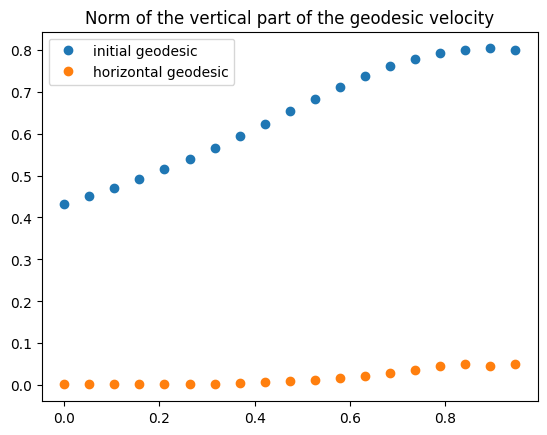

In [15]:
geod_vertical_norm = curves_r2.metric.norm(geod_velocity_ver, geod[:-1])

hgeod_velocity = (n_times - 1) * (hgeod[1:] - hgeod[:-1])
hgeod_velocity_ver = curves_r2.fiber_bundle.vertical_projection(
    hgeod_velocity, hgeod[:-1]
)
hgeod_vertical_norm = curves_r2.metric.norm(hgeod_velocity_ver, hgeod[:-1])

plt.figure()
plt.plot(times[:-1], geod_vertical_norm, "o", label="initial geodesic")
plt.plot(times[:-1], hgeod_vertical_norm, "o", label="horizontal geodesic")
plt.legend()
plt.title("Norm of the vertical part of the geodesic velocity")
plt.show()

We can also check that this horizontal geodesic does not change if we resample the end curve.

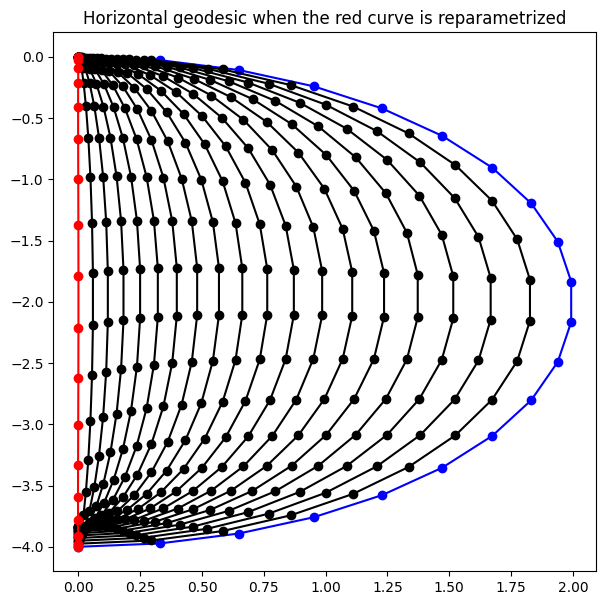

In [16]:
hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a, curve_b_resampled)
hgeod = hgeod_fun(times)

plot_geodesic(hgeod)
plt.title("Horizontal geodesic when the red curve is reparametrized")
plt.show()

Finally, we can check that the quotient distance remains approximately constant for any parametrizations of the curves.

In [17]:
print(curves_r2.quotient.metric.dist(curve_a, curve_b))
print(curves_r2.quotient.metric.dist(curve_a_resampled, curve_b))
print(curves_r2.quotient.metric.dist(curve_a_resampled, curve_b))
print(curves_r2.quotient.metric.dist(curve_a, curve_b_resampled))

1.7862021494546856
1.7857776083275845
1.7857776083275845
1.786264087205128


## Example 2: 3D curves

Below we follow similar steps for curves in $\mathbb R^3$. In this example, we can see that the horizontal geodesic "straightens out" the original geodesic.

In [18]:
k_sampling_points = 100

r3 = Euclidean(dim=3)
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3,
    k_sampling_points=k_sampling_points,
)

In [19]:
parametrized_curve_a = lambda x: gs.transpose(
    gs.stack((gs.cos(2 + 8 * x), gs.sin(2 + 8 * x), 2 + 10 * x))
)
parametrized_curve_b = lambda x: gs.transpose(
    gs.stack((gs.cos(4 + 8 * x), gs.sin(4 + 8 * x), 2 + 10 * x))
)

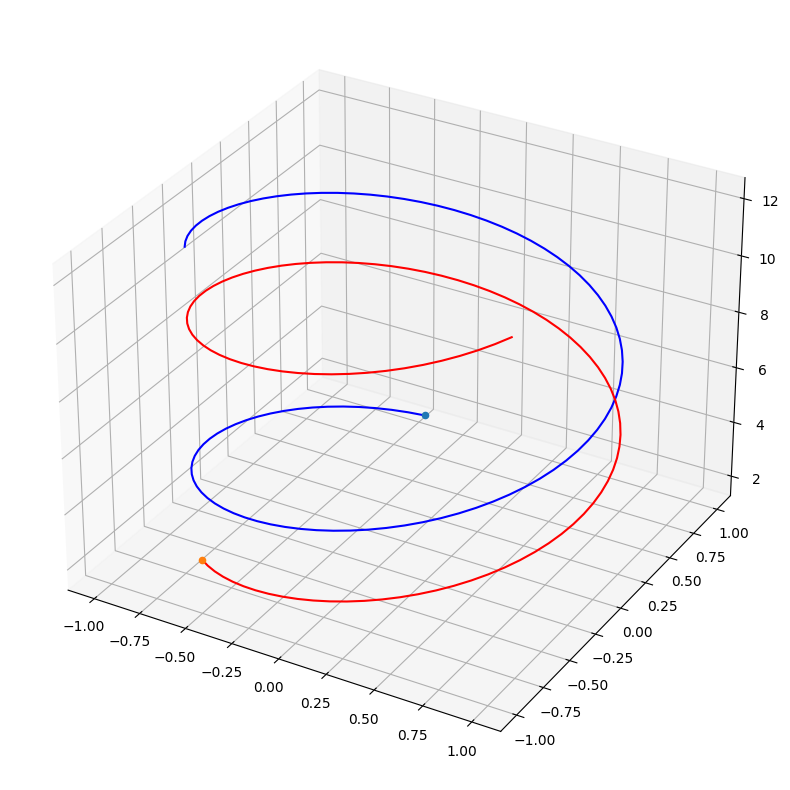

In [20]:
def plot_curve_3d(curve, fmt="k", ax=None, add_origin=True):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        curve = insert_zeros(curve, axis=-2)

    ax.plot(*[curve[:, k] for k in range(3)], fmt)
    ax.scatter(*[curve[0, k] for k in range(3)], fmt)
    return ax


sampling_points = gs.linspace(0.0, 1.0, k_sampling_points)
curve_a_trans = parametrized_curve_a(sampling_points)
curve_b_trans = parametrized_curve_b(sampling_points)


ax = plot_curve_3d(curve_a_trans, "b", add_origin=False)
plot_curve_3d(curve_b_trans, "r", ax=ax, add_origin=False)
plt.show()

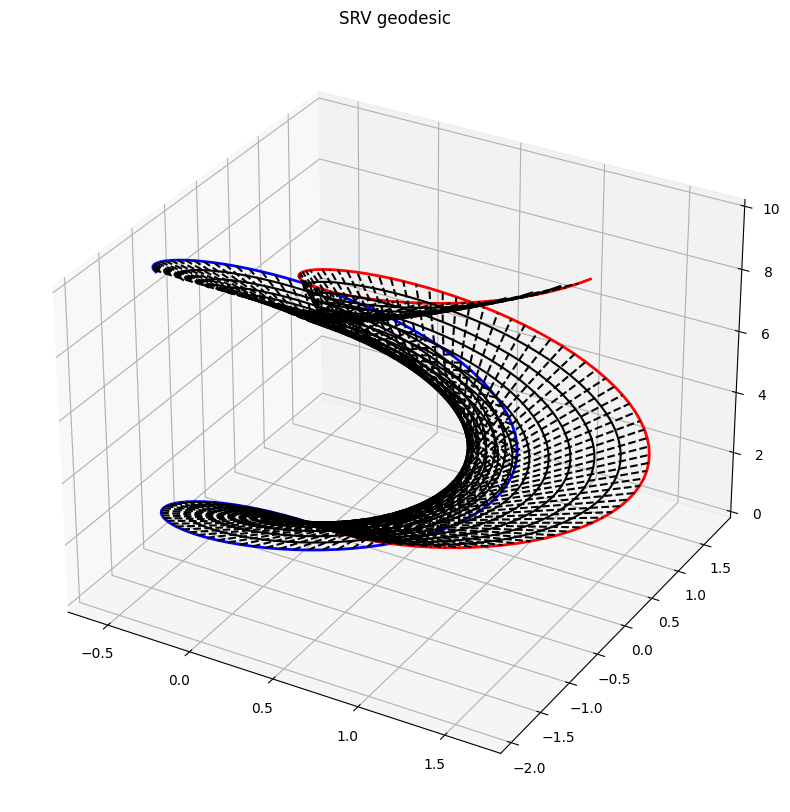

In [21]:
def plot_geodesic_3d(geod_points, ax=None, add_origin=True):
    n_times = geod_points.shape[0]
    k_sampling_points = geod_points.shape[-2] + 1

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        geod_points = insert_zeros(geod_points, axis=-2)

    ax.plot(*[geod_points[0, :, k] for k in range(3)], "-", c="b", linewidth=2)
    ax.plot(*[geod_points[-1, :, k] for k in range(3)], "-", c="r", linewidth=2)
    for i in range(1, n_times - 1):
        ax.plot(*[geod_points[i, :, k] for k in range(3)], "-", c="k")
    for j in range(k_sampling_points - 1):
        ax.plot(*[geod_points[:, j, k] for k in range(3)], "--", c="k")

    return ax


curve_a = curves_r3.projection(curve_a_trans)
curve_b = curves_r3.projection(curve_b_trans)


geod_fun = curves_r3.metric.geodesic(curve_a, curve_b)

n_times = 20
times = gs.linspace(0.0, 1.0, n_times)
geod = geod_fun(times)

plot_geodesic_3d(geod)
plt.title("SRV geodesic")
plt.show()

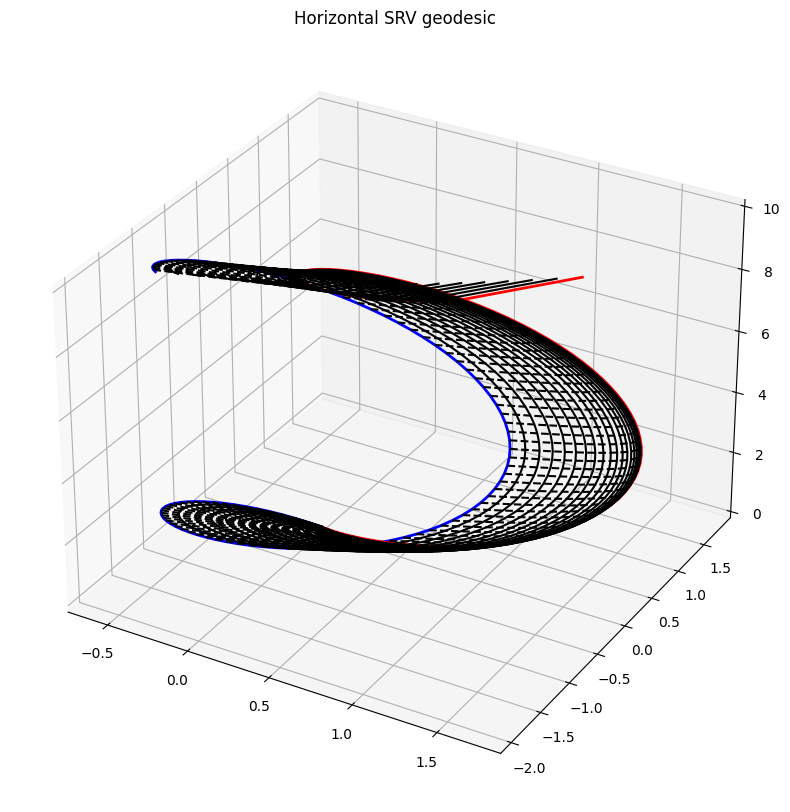

In [22]:
curves_r3.equip_with_group_action("reparametrizations")
curves_r3.equip_with_quotient_structure()

hgeod_fun = curves_r3.quotient.metric.geodesic(curve_a, curve_b)
hgeod = hgeod_fun(times)

plot_geodesic_3d(hgeod)
plt.title("Horizontal SRV geodesic")
plt.show()

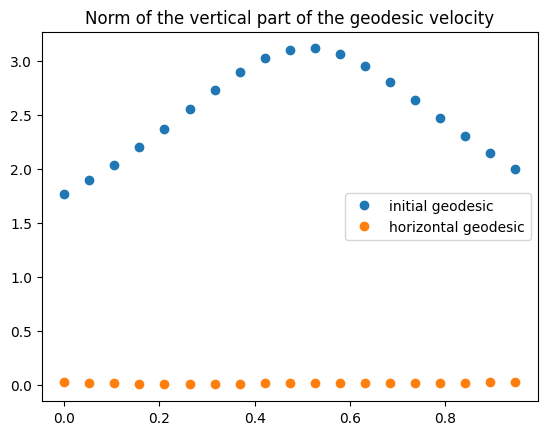

In [23]:
geod_velocity = (n_times - 1) * (geod[1:] - geod[:-1])
geod_velocity_ver = curves_r3.fiber_bundle.vertical_projection(geod_velocity, geod[:-1])
geod_vertical_norm = curves_r3.metric.norm(geod_velocity_ver, geod[:-1])

hgeod_velocity = (n_times - 1) * (hgeod[1:] - hgeod[:-1])
hgeod_velocity_ver = curves_r3.fiber_bundle.vertical_projection(
    hgeod_velocity, hgeod[:-1]
)
hgeod_vertical_norm = curves_r3.metric.norm(hgeod_velocity_ver, hgeod[:-1])

plt.figure()
plt.plot(times[:-1], geod_vertical_norm, "o", label="initial geodesic")
plt.plot(times[:-1], hgeod_vertical_norm, "o", label="horizontal geodesic")
plt.legend()
plt.title("Norm of the vertical part of the geodesic velocity")
plt.show()

## References

.. [SKJJ2011] A. Srivastava, E. Klassen, S. H. Joshi and I. H. Jermyn,
    "Shape Analysis of Elastic Curves in Euclidean Spaces,"
    in IEEE Transactions on Pattern Analysis and Machine Intelligence,
    vol. 33, no. 7, pp. 1415-1428, July 2011.

.. [L2017] A. Le Brigant,
    "A discrete framework to find the optimal matching between manifold-valued curves,"
    in Journal of Mathematical Imaging and Vision, 61,
    pp. 40-70, 2019.